<a href="https://colab.research.google.com/github/ximenina/escuelaverano/blob/master/Representaciones_vectoriales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Escuela de Verano PLN 2020**. Sesión práctica, parte 2

En los siguientes ejercicios, exploraremos diferentes métodos de representar nuestros corpus en un espacio vectorial. Iniciemos importando las librerias necesarias. No modifiques esta celda

In [ ]:
#dado un pequeño corpus, clasificar con diferentes tipos de representaciones vectoriales
import sklearn
import nltk
import sys
from tqdm import tqdm
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import matplotlib.pyplot as plt
import collections
import nltk
nltk.download('movie_reviews')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews
from nltk.stem import SnowballStemmer
import numpy as np
import random
import scipy as sp
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

np.random.seed(0)
random.seed(0)

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Sección 1: One-hot encoding

Iniciamos con un toy dataset para familiarizarnos con las representaciones vectoriales para clasificación de textos. Nuesto toy dataset consiste de 8 documentos para entrenar un modelo y 4 documentos para evaluar. La meta es classificar documentos en dos categorias: *Comida y Deportes*. Como mencionamos en el taller introductorio, una forma de representar texto en vectores es utilizando **one-hot encoding**. En esta parte de los ejercicios crearemos representaciones one-hot y entrenamos un modelo de regresión logística para clasificar.

In [ ]:
train = ['A Estefania le encanta comer helado', "Jorge va a cenar pizza y de postre va a comer helado", 'Juan siempre bebe agua cuando juega un partido de futbol',
          "Me encanta ver y jugar futbol, es mi ejercicio favorito", "Me encantaria jugar algún deporte de manera profesional",
          "Quisiera comer pizzas y hamburguesas y seguir sana", "Juego beisbol de lunes a viernes, es gran ejercicio", "Se me antoja una hamburguesa con papas"]
test = ["Los invitados estan emocionados por comer helado", 'Hay que ver el partido de beisbol', 'me encanta el sushi', "Esta tarde, jugaremos golf"]


train_labels = ['comida', 'comida', 'deporte', 'deporte', 'deporte', 'comida', 'deporte', 'comida']
test_labels = ['comida', 'deporte', 'comida', 'deporte' ]


label_ints = {"comida":0, "deporte":1}



Definimos un stemmer que nos permite estandarizar nuestro texto. Especificamente, stemming nos permite remover la inflexión de las palabras. 

Jugar --> Jug

Jugaremos --> Jug

In [ ]:
es_stop = stopwords.words('spanish') #definimos nuestra lista de stop words
es_stemmer = SnowballStemmer('spanish') #stemmer


def stems(string, stemmer,stop):
  #Lista de stems
  stem_string = []

  #ignoraremos puntuación
  punctuation = '!@#$%^&*()\'\"_+<>?:.,;-' 
  for word in string.lower().split():
    #Elimina stopwords
    if word in stop or word in punctuation:
      pass
    else:
      stem_string.append(stemmer.stem(word))
  return stem_string 


Para iniciar la creación de nuestros vectores debemos utilizar solo nuestro vocabulario del *training set*. Para asignar una representación vectorial a tokens del test set que no esten presentes en nuestro vocabulario, utilizamos una token especial: `<unk>` 





In [ ]:
train_tokens = [stems(item, es_stemmer, es_stop) for item in train] #obtenemos los tokens del training
all_tokens = np.concatenate(train_tokens) 
sorted_set = sorted(set(all_tokens).union(set(["<unk>"]))) #agregamos token para representar out-of-vocabulary tokens


#Ejercicio 1: Crear una función que asigne un vector one-hot a cada token de nuestro vocabulario

```
diccionario = {}
for i, token in enumerate(vocab):
  ..... creamos un vector de zeros del tamaño de nuestro vocabulario
  ..... asignamos un 1 en la posición i del vector
  ..... asignamos vector a nuestro token en el diccionario
```





In [ ]:

def one_hot_vectors(vocab):
  '''
  INPUT: training vocab set i.e. (“a”,“béisbol”,“comer”,“estefanía”,“gusta”,“jugar”,“le”,“pizza”,“sushi”,“y”)

  OUTPUT:  un diccionario donde la clave es el token y el valor es un vector one-hot

   { “a” : [1,0,0,0,....], 
    “béisbol” : [0,1,0,0,0,...],
    “comer” : [0,0,1,...] , 
    }

  '''
  
  vector_lookup = {} #creamos un diccionario vacío
  #por cada palabra en nuestro vocabulario
  #nuestros vectores serán del tamaño de nuestro vocabulario
  #insertamos un valor de 1 en la posición de nuestro token
  #agregamos a vector_lookup


  return vector_lookup


Ya que tenemos nuestro vector look up, podemos utlizarlo para convertir nuestros documentos en listas de números. La función `featurize_documents` asigna un vector por palabra en cada documento y los concatena para formar un vector por documento (ya que ese es el formato que necesitamos para nuestro clasificador de regresión logística). Adicionalmente, necesitamos que todos los documentos tengan vectores del mismo tamaño. La función agrega `padding` a secuencias de números mas cortas que la secuencia más larga, especificamente, agregamos ceros para llenar los vectores.

In [ ]:
def featurize_documents(documents, vector_map):

  """

  """
  featurized_dataset = []
  for doc in documents:
    cur_doc = []

    #removemos stop words, puntuación e inflexiónes
    stemmed_doc = stems(doc, es_stemmer, es_stop)
    for token in stemmed_doc: #por cada palabra en nuesto documento
      if token in vector_map: #si la palabra existe es nuestro vocabulario de entrenamiendo
        cur_doc += vector_map[token] #agregamos el vector correspondiente a nuesta lista
      else:
        cur_doc += vector_map["<unk>"] #agregamos el vector del token 'unk'

    #pad to max len 624
    padded = np.zeros((624))
    padded[0:len(cur_doc)] = np.array(cur_doc)
    
    featurized_dataset.append(padded)

  return featurized_dataset

Creamos nuestros vectores por documento, y representamos las categorías con números. Y estamos listos para entrenar un toy classifier!

In [ ]:
 vector_map = one_hot_vectors(sorted_set) #obtenemos nuestros vocabulario con vectores correspondientes
 features_train = featurize_documents(train, vector_map) #extraemos vectores del train set
 features_test = featurize_documents(test, vector_map)  #extraemos vectores del test set

 train_labels_int = [label_ints[label] for label in train_labels] #obtenemos la representación númerica de las etiquetas
 test_labels_int = [label_ints[label] for label in test_labels]

Entrenamos utilizando el train set y evaluamos utilizando el test set

In [ ]:
clf = LogisticRegression(random_state=0).fit(features_train, train_labels_int)

print("Predicciones: ", clf.predict(features_test))
print("Categorías reales: ",test_labels_int )
print("Exactitud: ", clf.score(features_test, test_labels_int))

Predicciones:  [0 0 1 1]
Categorías reales:  [0, 1, 0, 1]
Precisión:  0.5


#Discusión: Nuestro clasificador solo logra clasificar dos documentos correctamente.  

1.   ¿Por que es que nuestro modelo no logró clasificar correctamente los documentos restantes, siendo documentos muy secillos?
2.   ¿Que tipo de información adicional podría ayudar a nuestro modelo?





#Análisis de sentimiento

Enfoquemonos en un ejemplo más práctico. Utilizaremos un corpus de críticas de cine para entrenar un clasificador de sentimiento. Empezamos con una función básica para cargar los textos con los que trabajaremos

In [ ]:
def read_corpus(category="all"):
    """
    input:  Especificamos una categoria o listas de categorias 
    output: textos, labels
    """
    if category == "all":
      files = movie_reviews.fileids()
    else:
      files = movie_reviews.fileids(category)

    return [[w.lower() for w in list(movie_reviews.words(f))]  for f in files], \
            [movie_reviews.categories(doc_id) for doc_id in files]

In [ ]:
text, labels = read_corpus()

#creamos un diccionario para transformar etiquetas en números
map_labels = {'neg':0, 'pos':1}
int_labels = [map_labels[label[0]] for label in labels]

#tenemos que separar nuestos datos en train set y test set. Usualmente se utiliza un dev set en
#el proceso de optimización. En nuestro modelo sencillo no lo utilizaremos.
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(text, int_labels,test_size = 0.2, random_state=42)


#necesitamos crear nuestro vocabulario usando el TRAINING SET
all_tokens = np.concatenate(X_train) 
sorted_set = sorted(set(all_tokens).union(set(["<unk>"]))) #agregamos token para representar out-of-vocabulary tokens


In [ ]:
print(len(sorted_set))

36353


Utilizar one hot vectors como representaciones con un vocabulario de 36000 tokens toma demasiada memoria. Suponiendo que nuestros documentos contienen 100 tokens cada uno, nuestra representación vectorial efectivamente sería más de 3 millones de valores por documento, en su gran mayoría ceros. En el taller aprendimos un poco sobre vectores de frecuencias. Trabajemos un poco en esa dirección.

#Sección 2: Vectores de frecuencias

Para empezar a crear un vector de frecuencias, necesitamos obtener un vocabulario correspondiente a las tokens únicas que ocurren en el train set.

In [ ]:
train = [" ".join(doc) for doc in X_train]  
test = [" ".join(doc) for doc in X_test]

en_stemmer = SnowballStemmer('english') #definimos stemmer en inglés
en_stop =  stopwords.words('english') #definimos stop words en inglés

Ya hemos definino un stemmer, lo utilizaremos también en estos ejercicios. Lo hemos colocado aquí para que se más sencillo observar la implementación de nuevo, pero es exactamente el mismo

In [ ]:
def stems(string, stemmer,stop):
  #Lista de stems
  stem_string = []

  #ignoraremos puntuación
  punctuation = '!@#$%^&*()\'\"_+<>?:.,;-' 
  for word in string.lower().split():
    #Elimina stopwords
    if word in stop or word in punctuation:
      pass
    else:
      stem_string.append(stemmer.stem(word))
  return stem_string 

#Ejercicio 2: Crea una función `get_vocab`, donde utilizando un corpus creas un vocabulario de N tokens únicas.

In [ ]:

def get_vocab(dataset):
  """
  input: una lista de documentos i.e  ['mary had a little lamb', 'twinkle twinkle little star', 'old macdonald had a farm']
  out: un set de palabras únicas en orden alfabético i.e. (a, farm, had, lamb, little, macdonald, mary, old, star, twinkle)

  recuerda que para cada documento, obtenemos tokens preprocesadas con la funcion stems i.e. token = stems(document, en_stemmer, en_stop)
  

  """
  vocab = set()
  #por cada documento en nuestro dataset
  # utilizamos el stemmer
  #por cada token en nuestros tokens
  #agregamos al set

  return sorted(vocab)




In [ ]:
vocab = get_vocab(train)


Este vocabulario lo utilizaremos para crear nuestros vectores. Creamos una función que tome una lista de documentos (train), y regrese una lista de diccionarios con conteos de palabras (de nuestro vocab). Esta manera de guardar información nos permitirá vectorizar los documentos rapidamente.

In [ ]:
def get_counts(documents):
  counts = []
  for i, document in tqdm(enumerate(documents)): #por cada documento
    doc_counts = {} #creamos un dictionary por documento
    tokens = stems(document, en_stemmer, en_stop) #obtenemos tokens procesadas
    for token in set(tokens): #por cada token de nuestro vocabulario
      doc_counts[token]= tokens.count(token) #agregamos a nuestro diccionario el token y el valor correspondiente a la frecuencia de ese token en el documento
    counts.append(doc_counts) #guardamos en diccionario
  return counts


In [ ]:
train_counts = get_counts(train)
test_counts = get_counts(test)

1600it [00:12, 125.70it/s]
400it [00:03, 125.08it/s]


#Utilizamos el vocabulario y los conteos para vectorizar los documentos

Ya que tenemos las frecuencias de nuestros documentos en un diccionario, necesitamos representar estas en forma vectorial.



In [ ]:
def vectorize(counts, vocab):
  vectorized_documents = []
  for i, doc in tqdm(enumerate(counts)):
    vector = []
    for item in vocab: #por cada token del vocabulario
      if item in doc.keys(): #si el token existe en nuestro documento 
        vector.append(doc[item])  #agregamos la frecuencia del token
      else:
        vector.append(0) #si no la frecuencia es cero
    vectorized_documents.append(vector) #guardamos el vector de cada documento

  return vectorized_documents

In [ ]:
train_vectors = vectorize(train_counts, vocab)
test_vectors = vectorize(test_counts,vocab)

1600it [00:10, 154.20it/s]
400it [00:02, 142.85it/s]


#Utilizamos un clasificador de regresión logística 

In [ ]:
clf = LogisticRegression(random_state=0).fit(train_vectors, Y_train)
print("Exactitud: ", clf.score(test_vectors, Y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Precisión:  0.83


Tips prácticos: Podemos utilizar funciones de Sklearn para hacer lo mismo de forma efectiva



```
#estamos ignorando muchos pasos de procesamiento 
vectorizer = CountVectorizer().fit(train).  #obtiene el vocabulario basado en el train set
train_vectors = vectorizer.transform(train) #vectoriza el train set
test_vectors = vectorizer.transform(test) #vectoriza el test set
```



#Sección 3: Explorando las propiedades de vectores continuos (word2vec)

En esta última sección nos enfocaremos en explorar algunas propiedades de vectores pre-entrenados con el algoritmo skip-gram (No entrenaremos modelos ni clasificaremos)

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'



--2020-08-31 09:08:18--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.95.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.95.93|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
x = word2vec.word_vec("test")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Reducimos las dimensiones a 2 utilizando PCA, para poder visualizar

In [ ]:

Z = PCA(n_components=2).fit_transform(word2vec.vectors)

Creamos un nuevo diccionario con el vocabulario y los nuevo vectores de dim=2

In [ ]:
words = [word for word in word2vec.vocab]
new_w2v = dict(zip(words,Z))

Creamos una función para visualizar vectores 

In [ ]:
def plot_words(coordinates,labels):
    
    r=0

    xs = [i[0] for i in coordinates]
    ys= [i[1] for i in coordinates]
    plt.scatter(xs,ys, marker='o', c='blue')
    for label,x,y in zip(labels, xs, ys):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

In [ ]:
print(new_w2v['horrible'])

[-0.30081317 -0.30673793]


Algunos ejemplos

In [ ]:
labels = ["amazing", "good", "fantastic", "disgusting", "bad", "horrible"]
coordinates = [new_w2v[word] for word in labels]

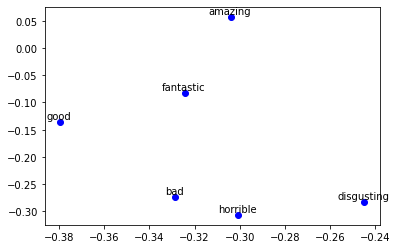

In [ ]:
plot_words(coordinates, labels)

In [ ]:
labels = ["man", "woman",  "queen", 'king']
coordinates = [new_w2v[word] for word in labels]

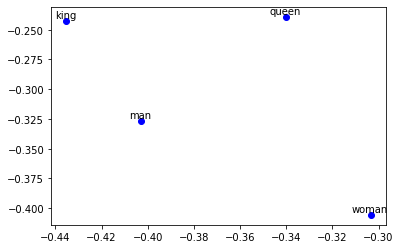

In [ ]:
plot_words(coordinates, labels)

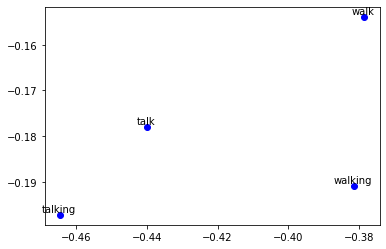

In [ ]:
labels = ["walk", "walking", 'talk', 'talking']
coordinates = [new_w2v[word] for word in labels]
plot_words(coordinates, labels)

1. Podemos explorar la composicionalidad de las palabras para ver que conceptos son los más similares

In [ ]:
result = word2vec.most_similar(positive=['woman', 'king'], negative=['man'])
for item in result:
  print(item)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


('queen', 0.7118192911148071)
('monarch', 0.6189674139022827)
('princess', 0.5902431011199951)
('crown_prince', 0.5499460697174072)
('prince', 0.5377321243286133)
('kings', 0.5236844420433044)
('Queen_Consort', 0.5235945582389832)
('queens', 0.518113374710083)
('sultan', 0.5098593235015869)
('monarchy', 0.5087411999702454)


2. usando la función `doesnt_match`, podemos ver que concepto no pertence a nuestra lista

In [ ]:
print(word2vec.doesnt_match("breakfast dog dinner lunch".split()))


dog


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


3. Podemos explorar la similitud entre palabras

In [ ]:
print(word2vec.similarity('cat', 'tiger'))
print(word2vec.similarity('cat', 'lion'))
print(word2vec.similarity('tiger', 'lion'))
print(word2vec.similarity('cat', 'kitten'))

0.5172962
0.3997731
0.5121041
0.74649847


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


4. Y extraer las palabras más similares a un query

In [ ]:
for item in word2vec.similar_by_word("cat"):
  print(item)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


('cats', 0.8099379539489746)
('dog', 0.7609456777572632)
('kitten', 0.7464985251426697)
('feline', 0.7326233983039856)
('beagle', 0.7150583267211914)
('puppy', 0.7075453996658325)
('pup', 0.6934291124343872)
('pet', 0.6891531348228455)
('felines', 0.6755931377410889)
('chihuahua', 0.6709762215614319)


In [ ]:
for item in word2vec.similar_by_word("woman"):
  print(item)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


('man', 0.7664012908935547)
('girl', 0.7494640946388245)
('teenage_girl', 0.7336829900741577)
('teenager', 0.631708562374115)
('lady', 0.6288785934448242)
('teenaged_girl', 0.6141783595085144)
('mother', 0.607630729675293)
('policewoman', 0.6069462299346924)
('boy', 0.5975908041000366)
('Woman', 0.5770983695983887)


#Material Adicional Opcional

#Term Frecuency-Inverse Document Frecuency (TF-IDF)

Los conteos que obtuvimos en la sección 2 pueden ser llamados "Term frecuencies". Adicionalmente, podemos calcular el "inverse document frecuency" para introducir la noción de peso en nuestras representaciones vectoriales.

Recuerden que el inverse document frecuency de un token *t* es igual a log(num de doc totales/num de documentos donde *t* ocurre)

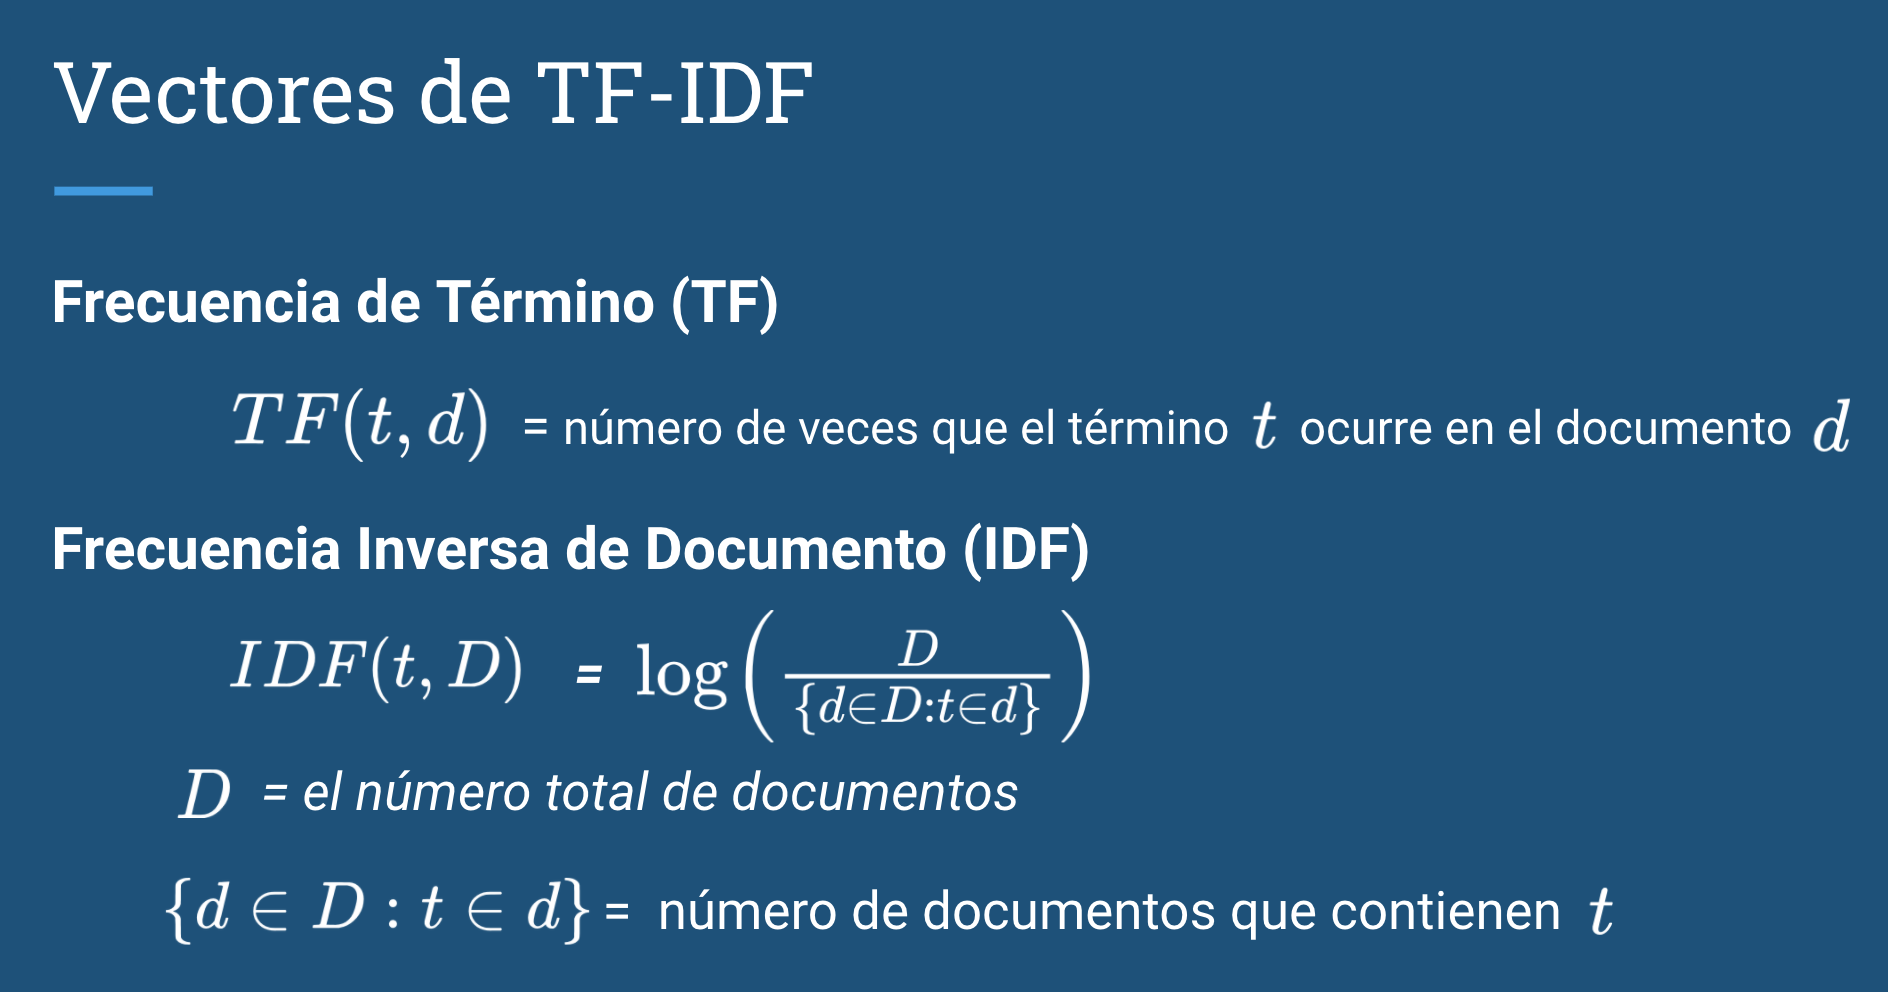

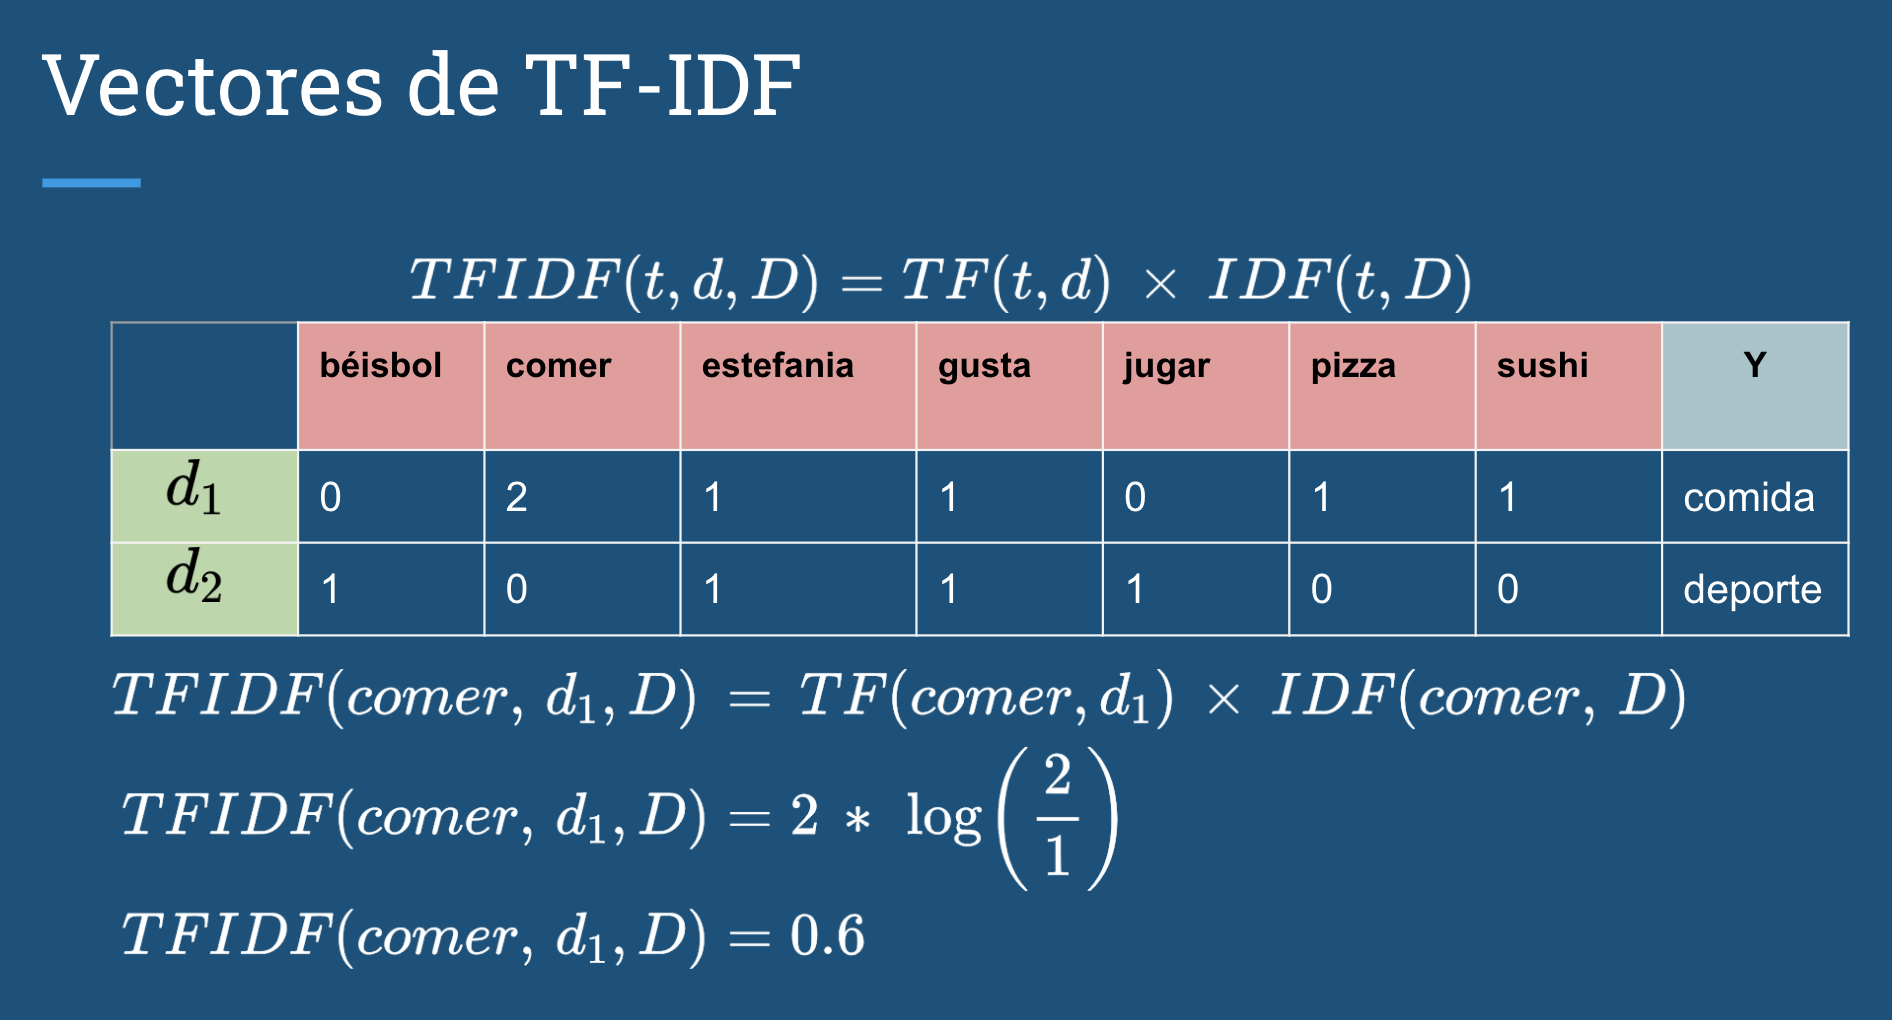

In [ ]:

#utilizamos el mismo vocabulario

word_idf_values = {}
for token in vocab:  #por cada palabra en el vocabulario
  doc_containing_word = 0 #empezamos el conteo de documentos que contienen el token
  for document in train_counts: 
      if token in document.keys():
        doc_containing_word += 1 #si el token existe en este documento, incrementamos
  word_idf_values[token] = np.log(len(train_counts)/(1 + doc_containing_word)) #agregamos el idf de la palabra a nuestro diccionario

Creamos una función donde dado un diccionario de counts (el output de  get_counts) crea un diccionario por documento conteniendo los tfidf's de cada palabra en ese documento.

In [ ]:
def get_tfidf(counts):
  tfidf = []
  for i, document in tqdm(enumerate(counts)):
    doc_vals = {}
    for token in document.keys():
      if token in word_idf_values.keys():

        doc_vals[token]= document[token] * word_idf_values[token]
      else:
        idf = np.log(len(train_counts)) #si la palabra no existe en nuestro diccionario idf asumimos que el numero de documentos conteniendo esa palabra es 1 (current document)
        doc_vals[token]= document[token] * idf #multiplicamos tf * idf

    tfidf.append(doc_vals)
  return tfidf

In [ ]:
tfidf_train = get_tfidf(train_counts)
tfidf_test = get_tfidf(test_counts)

1600it [00:00, 4837.55it/s]
400it [00:00, 4366.80it/s]


Vectorizamos utilizando la misma función que usamos previamente

In [ ]:
train_vectors = vectorize(tfidf_train, vocab)
test_vectors = vectorize(tfidf_test,vocab)

1600it [00:10, 158.24it/s]
400it [00:02, 159.19it/s]


In [ ]:
clf = LogisticRegression(random_state=0).fit(train_vectors, Y_train)
print("Exactitud: ", clf.score(test_vectors, Y_test))

Precisión:  0.8175


#Discusión: Utilizando TF-IDF en este caso, nos da un peor resultado que utilizando solo frecuencias. 



1.   ¿Que tipo de información importante estamos perdiendo?
2.   ¿De que maneras podemos remediar esto?

